# Calculate the GW modes for each exoplanet that has the needed parameters in the dbase.

In [1]:
# Started WEG  20180320. 
# See the gwtools.py which has utility and strain functions in it
# and ExopDBase notebook that can download a new csv exop database.

# References
P. Amaro-Seoane et al. "Triplets of supermassive black holes: astrophysics, gravitational waves and detection," MNRAS 402 2308-2320 (2010).

P. C. Peters and J. Mathews, "Gravitational Radiation from Point Masses in a Keplerian Orbit," Phys. Rev. 131 (1963) 435-440.

Michele Maggiore, "Gravitational Waves. Volume 1: Theory and Experiments," Oxford Univ. Press, 2008.

Shane Larson, "Sensitivity Curves for ..."  http://www.srl.caltech.edu/~shane/sensitivity/

Neil Cornish and Travis Robson, "The construction and use of LISA sensitivy curves," https://arxiv.org/abs/1803.01944

In [2]:
import sys, os
import numpy as np
import pandas as pd
import gwTools as gwt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.interpolate as spint

## Directories for the dbase and to save plots.

In [3]:
thisDir = os.getcwd()  # This is the /python subdirectory.
cvsDir = thisDir + '/../dbases/'  # Will the /../ work on non-Unices?
pixDir = thisDir + '/../pix/'

## Read the CSV and drop the rows/exops with NaN in the important fields.  See ExopDBase.ipynb and re-run it for updating the dbase.

In [5]:
cvsFileName = cvsDir + 'exopP_20180403_110820.csv'
print('Using database file ' + cvsFileName)
with open(cvsFileName, 'r') as ifile:
    print(ifile.readline(), '\n', ifile.readline() )  #Print a couple of lines and reset the pointer.

    ifile.seek(0);

    dbData = pd.read_csv(ifile)  # Read in the whole file to a Panda Dataframe, handles NaN's nicely, see below.
    #ifile.close()  # Should close when you leave the "with."

Using database file /home/gabella/Documents/astro/exop/exoplanetsMath/python/../dbases/exopP_20180403_110820.csv
pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
 
 HD 142022 A,b,Radial Velocity,1928.00000000,3.030000,0.530000,5.10000,35.87,0.99,2014-05-14,27.88



In [6]:
dbData.head(10)  # NaN's show up when the field has no data.  Need both masses, eccentricity, semimajor axis, 
# and distance.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.000000,3.0300,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.000000,3.3800,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.000000,0.8900,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.710000,0.4900,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.818049,0.0368,0.0000,0.398,35.80,0.84,2015-03-26,27.93
5,HD 212301,b,Radial Velocity,2.245715,0.0360,0.0000,0.450,52.72,1.27,2014-05-14,18.97
6,CHXR 73,b,Imaging,NaN,210.0000,NaN,12.569,NaN,0.35,2014-05-14,NaN
7,CT Cha,b,Imaging,NaN,440.0000,NaN,17.000,165.00,NaN,2014-05-14,NaN
8,HD 196067,b,Radial Velocity,3638.000000,5.0200,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.000000,2.1800,0.0300,3.070,78.00,1.12,2016-11-10,12.82


### Drop the exops/rows with NaN in the following fields: pl_orbeccen (eccentricity), pl_orbper (orbital period), pl_obssmax (semimajor axis), pl_bmassj (planet mass), st_dist (distance to host star), st_mass (star mass)

In [7]:
# {"pl_hostname", "pl_letter", "pl_discmethod", "pl_orbper", \
# "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "st_dist", "st_mass", \
# "rowupdate", "st_plx"}
print('Length all data, dbData ', len(dbData) )
aData = dbData.dropna(axis = 0, how = 'any', subset = ['pl_orbeccen'])
print('Length with pl_orbeccen\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbper'])
print('Length with pl_orbper\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbsmax'])
print('Length with pl_orbsmax\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_bmassj'])
print('Length with pl_bmassj\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_dist'])
print('Length with st_dist\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_mass'])
print('Length with st_mass\t', len(aData) )

Length all data, dbData  3708
Length with pl_orbeccen	 1172
Length with pl_orbper	 1172
Length with pl_orbsmax	 1107
Length with pl_bmassj	 1027
Length with st_dist	 920
Length with st_mass	 910


In [8]:
#  So adata is the working exoplanet data frame after filtering as a Panda DataFrame.  Later should consider 
#  filling in missing data with Kepler or other calculations.

##  Physical Constants, made explicit here.  The CalTech exop dbase has an FAQ on the units they use for each parameter.

In [9]:
# Some scipy.constants for comparison mostly.
from scipy.constants import speed_of_light, gravitational_constant, c, G, pi

massSun = 1.989e30; #(*kg *)
massJ = 1.898e27; #(* kg *)
massE = 5.972e24; #(* kg *)
massJe = massJ/massE; #(* Jupiter mass is 317.9 earth masses *)
massJs = massJ/massSun; #(* relative to the sun's mass *)

pc = 30.86e15; #(* meters, parsec *)
au = 149.6e9; #(* meters, astron unit *)

cee = 299792458.0; #(* meters/s, speed of light *)
print('Compare my cee ', cee, ' and scipy.constants ', speed_of_light)
cee = speed_of_light # Use the scipy.constants one.
secsYear = 365.24*24.0*3600.0; #(* s, number of seconds in a year *) # What do astronomers use for this conversion?
secsDay = 24.0*3600.0; #(* s, number of seconds in a day *)

bigG = 6.67408e-11; #(* SI Gravitational constant, m^3/kg/s *)
print('Compare my bigG ', bigG, ' and scipy.constants ', gravitational_constant)
bigG = gravitational_constant

rscon = 2*bigG*massSun/(cee*cee) #(* 2955.43 m, solar mass Scharzschild radius *)
lunits = bigG*massSun/(cee*cee) #(* meters per solar mass, units of G=c=1, no factor
#of 2 as in Schwarzschild radius *)
masscon = lunits; #(* m, G Msol/c^2, for 1 solar mass *)
powercon = cee**5/bigG  #(* 3.628e52 W, c^5/G, W/unit since P is dimensionless in G=c=1 units *)
energycon = (cee**4)/bigG  #(* 1.210e44 J/m, c^4/G *)

Compare my cee  299792458.0  and scipy.constants  299792458.0
Compare my bigG  6.67408e-11  and scipy.constants  6.67408e-11


## Calculate some GW amplitudes for each exoplanet.

### Make a plot of the maximum strain mode number versus eccentricity.  This "n-star" is used to truncate the number of GW modes used.

Text(0.5,1,'The n-star, where the g(n,e) curve\n comes back to 1/20th the peak value')

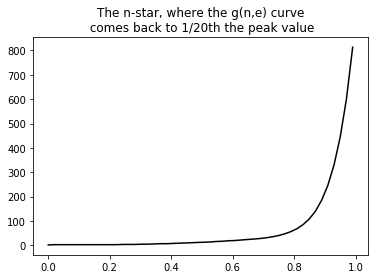

In [10]:
ecc = np.linspace(0., 0.99, 50)
nstar = [ gwt.aNmax(uu) for uu in ecc ]
plt.plot(ecc, nstar, 'k-')
plt.title('The n-star, where the g(n,e) curve\n comes back to 1/20th the peak value')

In [11]:
aData.head(4)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.00,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.00,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.00,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.71,0.49,0.5110,3.370,17.62,0.90,2014-05-14,56.76


## Create a numpy array of GW strain amplitudes for that planet and append to the table.

In [ ]:
# Actually append n_min, n_max, numpy array of GW strains h.
# In the Mathematica JustStrainPlots.nb, about 40% down, calc hhVfreq first time.

hhmodesCol = []  # Setup a list of the hhmodes that will be appended to the dataframe.
modesCol = [] # The modes set acually used for the calculation, int(modeMin) to int(modeMax)+1
freq0Col = [] # Collect the orbital frequency that was used.

for irow in range(len(aData)):
    # Calculate the SI parameters needed by the strains and the strain "front coefficient."
    
    orbeccen = aData['pl_orbeccen'].values[irow]
    modeMax = gwt.aNmax( orbeccen )  # The "max" mode number where g(n,e) returns to 1/20th its peak value.
    modeMin = gwt.aNmin( orbeccen )  # Either 1 for e>0 or 2 for e=0.
    #
    m1 = aData['pl_bmassj'].values[irow]*massJ
    m2 = aData['st_mass'].values[irow]*massSun
    smax = aData['pl_orbsmax'].values[irow]*au
    dL = aData['st_dist'].values[irow]*pc
    freq0 = 1.0/(aData['pl_orbper'].values[irow]*secsDay)
    #aData['pl_orbper']*secsDay
    frontCoeff = np.power(bigG,5/3.)/cee**4 * 2 * np.sqrt(32/5.) * np.power( gwt.chirpM(m1,m2), 5/3.)*\
    np.power((2*np.pi*freq0), 2/3.)/dL
    if irow > 6 and irow < 15:
        print('irow is ', irow, ' ,frontCoeff is ', frontCoeff, ' pl_orbeccen is ', orbeccen)

    # Now loop over the GW modes.
    hhmodes = [ frontCoeff*gwt.ggSimp(uu, orbeccen) for uu in range(int(modeMin), int(modeMax)+1)  ]
    modes = [ uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    
    # Append to the list.
    hhmodesCol.append( hhmodes )
    modesCol.append( modes )
    freq0Col.append( freq0 )
        

In [ ]:
print( len(hhmodesCol[0] ) )
print( hhmodesCol[0] )
print( modesCol[0] )

In [ ]:
#Append the hhmodesCol to the dataframe, for ease of getting at the other attributes.
aData['freq0'] = freq0Col
aData['modes'] = modesCol
aData['hhmodes'] = hhmodesCol

In [ ]:
aData.head(3)

## Use the calculated data and the Larson or Cornish S_n(f) curve averaged/integrated over 1 year, or 4 years.

The Larson curve from http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html , for dimensionless strain says 1 year integration time (?)

In [ ]:
# Load one or other of the Larsen curves
larson1Yr = 'scg_5672_hdimless_1yearInten.dat';  # This is likely the wrong arm lengths, etc, even for Larson.
larson1Yr = 'scg_5597_2W_2p5e9m.dat'  # ASD's in per root Hz!!!
larsonDimless1Yr = pd.read_csv( thisDir + '/' + larson1Yr, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonDimless1Yr.head(3)

In [ ]:
# Append the 1 year integrated dimension-less by dividing ASD by sqrt(1 year in secs).  Check this!!
larsonDimless1Yr['h[dimless]'] = larsonDimless1Yr['ASD[Hz^-1/2]'].values/np.sqrt(1.0*secsYear)

In [ ]:
larsonDimless1Yr.plot(x = 'freq[Hz]', y = 'h[dimless]', logy=True, logx=True, grid=True)

In [ ]:
# plotting different dataframes in same plot
#ax = df1.plot()
#df2.plot(ax=ax)

ax = larsonDimless1Yr.plot(x = 'freq[Hz]', y = 'h[dimless]', logy=True, logx=True, grid=True)
for irow in range(len(aData)):
#for irow in range(3):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    ax.set_title('One Year Noise and Exops')
    

In [ ]:
for irow in range(len(aData) ):
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438' and \
    aData['pl_letter'].values[irow] == 'b':
        theRow = irow
        print( aData.values[irow] )

In [ ]:
gwt.aNmax(0.06)  # If e>0 always have at least three modes, n = 1,2,3 .

In [ ]:
xx = np.linspace(0,0.95, 60)
yy= [ gwt.aNmax(uu) for uu in xx ]
plt.semilogy(xx, yy, 'k-')

## Calculate the signal-to-noise ratio for each planet.

In [ ]:
# Will need to interpolate the S_n(f) functions.
# Do the linear interpolation in the log-space since it is so linear there.
class snLinInterp:

    """Input the numpy arrays of freqs and sns and returns a class with
    a __call__ function.  Not good checks for values <=0 or if you are interpolating
    outside the range it was setup in, so use carefully.
    """
    def __init__(self, freqs, sns):
        from scipy.interpolate import interp1d
        # Check lenght of arrays agree.
        if len(freqs) != len(sns):
            print('***class snLinInterp: error, arrays lengths disagree, len(freqs) ', len(freqs), ' and '\
                 'len(sns) is ', len(sns) )
        else:
        # Check for zero in each array.  Cannot use x[x>0] as usual, need arrays coordinated.
            idrop = []
            for ii in range(len(freqs)):
                if freqs[ii] <= 0 or sns[ii] <= 0:
                    idrop.append(ii)

            self.freqs = np.delete(freqs,idrop)
            self.sns = np.delete(sns, idrop)
            self.logFreqs = np.log10(self.freqs)
            self.logSns = np.log10(self.sns)
            self.myInterp1D = interp1d(freqs, sns)  # Leave it linear for now. scipy.interpolate.
            self.minFreq = np.min(self.freqs)
            self.maxFreq = np.max(self.freqs)  # Can only interp between the values min freq and max.
        
    def __call__(self, uu):  # Checking for negatives and zeros is a pain, just do not do it for now!!
        return( self.myInterp1D(uu) )
        
xx = np.linspace(0.1, 12.3, 20)
yy = np.power(xx,4)
snInterp = snLinInterp(xx, yy )  # Has the __call__ method, so makes a 1D function.
xint = [3.33, 6.6, 11.11]
yint = snInterp(xint)
ax = plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
# set_title('Testing the linear interp in log-log space of the dep and indep variables.')
print( 'Testing the linear interp in log-log space of the dep and indep variables.' )
plt.show()

# Test handling of the negatives and zero values!
xx = np.linspace(-5.5, 12.3, 30)
yy = np.power(xx,4)
snInterp2 = snLinInterp(xx, yy) # trying negatives for x but all positives for y, should drop both values.

xint = np.array([3.33, 6.6, 11.11])
yint = snInterp(xint)
plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
plt.show()
plt.plot(xx,yy,'ko-', xint, yint, 'bo')
plt.show()

In [ ]:
# Load one or other of the Larsen curves
larsonASDName = 'scg_5597_2W_2p5e9m.dat';  # This has right arm lengths, other nos. seem reasonable.
larsonASD = pd.read_csv( thisDir + '/' + larsonASDName, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonASD.head(3)

In [ ]:
ax = larsonASD.plot(x = 'freq[Hz]', y = 'ASD[Hz^-1/2]', logy=True, logx=True, grid=True)


In [ ]:
# Append the PSD, per root Hz.  What we need for the SNR**2 formualae.
larsonASD['PSD[Hz^-1]'] = larsonASD['ASD[Hz^-1/2]']**2
bx = larsonASD.plot(x = 'freq[Hz]', y = 'PSD[Hz^-1]', logy=True, logx=True, grid=True)

In [ ]:
# Setup the interpolating for the S_n(f) int he range below f = 2e-3 Hz.
xfreqsA = larsonASD['freq[Hz]'].values
yPSDA = larsonASD['PSD[Hz^-1]'].values # Define the full data as numpy arrays.
#(xfreqs, yPSD) = [ (uu, vv ) if uu <= 2e-3 for (uu, vv) in (xfreqsA, yPSDA)  ]
xfreqs = xfreqsA[xfreqsA<=2e-3]
yPSD = yPSDA[xfreqsA<=2e-3]

plt.loglog( xfreqs, yPSD, 'k-')

In [ ]:
mySnInterp = snLinInterp( xfreqs, yPSD )
# To handle the really low frequency modes use the linear fit in the log-log space:
# Larson formula for now.  From Mathematica GWExopSNR.nb
#ssubn[freq_] := 0.1642*10^-48/freq^4
#
# Actually the fit in the python notebook for the left hand side of the S_n(f) from Larson's Sqrt[S_n(f)] 
# was TeXForm[f^-3.9946\cdot 1.6421 \cdot 10^-49]  .
def ssubn(freq):
    return( (0.1642e-48/freq**4) )

# It is the sum over the modes.
intTime = 1.0*secsYear  # Integration time in seconds.

SNRCols = []
for irow in range(len(aData) ):
    freq0 = aData['freq0'].values[irow]
    modes= aData['modes'].values[irow]
    hhmodes = aData['hhmodes'].values[irow]
    SNRSqSum = 0.0
    for jmodes in range(len(modes) ):   # Calc the SQUARE of the SNR!
        amode = modes[jmodes]
        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/ssubn(amode*freq0)
#        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/mySnInterp(amode*freq0)
    SNRCols.append( np.sqrt(SNRSqSum) )
        
print('len(SNRCols) is ', len(SNRCols) )
aData['SNR']=SNRCols
print('len(aData) is ', len(aData) )
    

In [ ]:
len(aData)

In [ ]:
aData.head(3)

In [ ]:
bData = aData.sort_values(by = 'SNR', ascending = False)
bData.head(3)

In [ ]:
# Print the table that Mathematica does and what is in the paper.
astr = 'name                \teccen\tper(days)\tSNR\tindex\n'
print(astr)
for ii in range(16):
    astr = '%-20s\t%6.4f\t%.3f\t%.3g\t%d'%\
    (bData['pl_hostname'].values[ii]+' '+bData['pl_letter'].values[ii], bData['pl_orbeccen'].values[ii], 
     bData['pl_orbper'].values[ii], 
     bData['SNR'].values[ii], ii)
    print(astr)


In [ ]:
1/(111.3*24*3600.)

In [ ]:
cData = aData.sort_values(by = 'pl_orbeccen', ascending = False)
cData.head(6)